# Preprocessing & Modeling

This notebooks contains my preprocessing of the data in preparation for modeling as well as the steps to select and train a regression model.  The product of this notebook will be a model that can be used for prediction.

------

## Contents<a id='Contents'></a>
* [XXXX](#introduction--feature-descriptions)
* [Imports & Reading Data](#imports--readingpreparing-data)
---

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../../../../DS_Mentorship_Projects/')
from utils import linear_model_selection

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/Concrete_Data_Yeh.csv')
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('csMPa', axis = 1)
y = df['csMPa']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

## Baseline Model (No relationship between predictor features and target feature)

In [5]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_cv_scores = cross_val_score(dumb_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
dumb_cv_score_mean = dumb_cv_scores.mean()
dumb_cv_score_std = dumb_cv_scores.std()

dumb_cv_score_mean

-278.6761494281668

In [6]:
dumb_reg.fit(X_train, y_train)
dumb_reg_constant = dumb_reg.constant_[0][0]
dumb_reg_constant

35.9220995145631

This "model" predicts the compression strength as the sample mean in every case (y = 35.922 + 0*X).

In [7]:
# Get r squared value for training data
dumb_reg.score(X_train, y_train)

0.0

For the training set, 0.0% of the variance in the target feature is explained by the model.

In [8]:
# Get mean squared error for test data.  This will be the baseline 
y_predict_baseline = dumb_reg.predict(X_test)
dumb_reg_test_mse = mean_squared_error(y_test, y_predict_baseline)
print("Baseline MSE:", dumb_reg_test_mse)

Baseline MSE: 283.72877665204663


## Methods for Model Selection

In [9]:
dummy_reg_dict = {'model': dumb_reg, 'is_ols': False, 'scaled_data': False, 'n_params': [0], 'parameters': None, 
            'coefficients': None, 'intercept': dumb_reg.constant, 
            'cv_score': dumb_cv_score_mean, 'cv_score_std': dumb_cv_score_std, 'test_mse': dumb_reg_test_mse}

### Best Subset Selection:

Code sampled from [R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016)](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html). 

In [10]:
best_models_subset_select = pd.DataFrame(dummy_reg_dict)

for i in range(1, 9):
    new_model = linear_model_selection.getBestKModel(X_train, y_train, X_test, y_test, k=i, regressor='OLS')
    best_models_subset_select = pd.concat([best_models_subset_select, new_model], axis=0, ignore_index=True)

Processed 8 model(s) on 1 predictor(s)
Processed 28 model(s) on 2 predictor(s)
Processed 56 model(s) on 3 predictor(s)
Processed 70 model(s) on 4 predictor(s)
Processed 56 model(s) on 5 predictor(s)
Processed 28 model(s) on 6 predictor(s)
Processed 8 model(s) on 7 predictor(s)
Processed 1 model(s) on 8 predictor(s)


In [11]:
best_models_subset_select

,model,is_ols,scaled_data,n_params,parameters,coefficients,intercept,cv_score,cv_score_std,test_mse
0,DummyRegressor(),False,False,0,None,None,None,-278.676149,26.268613,283.728777
1,LinearRegression(),True,False,1,[cement],[0.07792767537004329],13.894509,-214.700791,7.410911,195.566040
2,LinearRegression(),True,False,2,"[cement, age]","[0.07464030127415472, 0.09049735479738762]",10.705233,-184.343140,8.397467,204.866418
3,LinearRegression(),True,False,3,"[cement, superplasticizer, age]","[0.06717644413944593, 1.170508717556895, 0.113...",4.490409,-138.291089,12.184980,179.705657
4,LinearRegression(),True,False,4,"[cement, slag, superplasticizer, age]","[0.08004337635664521, 0.05567088104327977, 1.1...",-2.887668,-117.327510,7.974205,166.146653
5,LinearRegression(),True,False,5,"[cement, slag, flyash, water, age]","[0.11315050495625445, 0.09724247649332822, 0.0...",29.23165,-104.603482,6.715694,135.349416
6,LinearRegression(),True,False,6,"[cement, slag, flyash, water, superplasticizer...","[0.10607090811321253, 0.08865757382480535, 0.0...",20.99748,-102.899464,7.232990,139.027926
7,LinearRegression(),True,False,7,"[cement, slag, flyash, water, superplasticizer...","[0.10774408025097179, 0.0905500599769832, 0.07...",17.067564,-103.148411,7.421625,138.970882
8,LinearRegression(),True,False,8,"[cement, slag, flyash, water, superplasticizer...","[0.11245418761334908, 0.09627841251483628, 0.0...",-0.819576,-103.239761,7.485769,137.955851


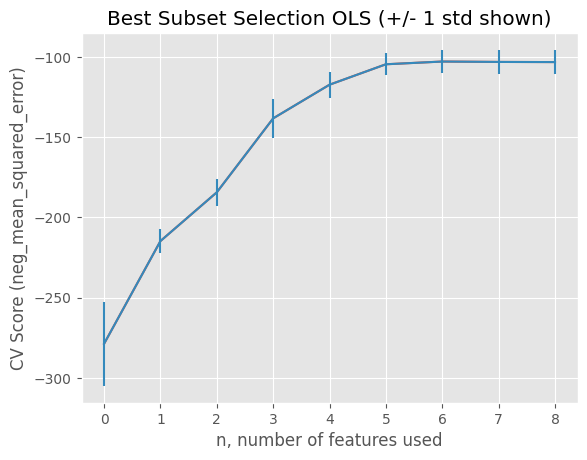

In [12]:
#Plot models' parameters vs. CV score
sns.lineplot(best_models_subset_select, x = 'n_params', y = 'cv_score')
plt.errorbar(x = best_models_subset_select['n_params'], y = best_models_subset_select['cv_score'], yerr = best_models_subset_select['cv_score_std'])
plt.title('Best Subset Selection OLS (+/- 1 std shown)')
plt.ylabel('CV Score (neg_mean_squared_error)')
plt.xlabel('n, number of features used')
plt.show()

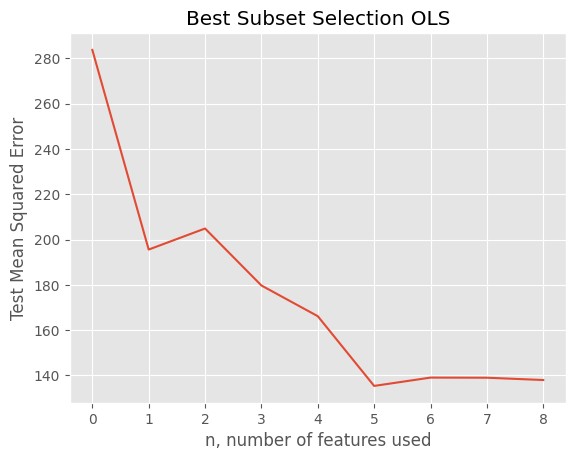

In [13]:
#Plot models' parameters vs. TestMSE
sns.lineplot(best_models_subset_select, x = 'n_params', y = 'test_mse')
plt.title('Best Subset Selection OLS')
plt.ylabel('Test Mean Squared Error')
plt.xlabel('n, number of features used')
plt.show()

In [14]:
best_subset_OLS_model = best_models_subset_select.iloc[5]
best_subset_OLS_model

model                                          LinearRegression()
is_ols                                                       True
scaled_data                                                 False
n_params                                                        5
parameters                     [cement, slag, flyash, water, age]
coefficients    [0.11315050495625445, 0.09724247649332822, 0.0...
intercept                                                29.23165
cv_score                                              -104.603482
cv_score_std                                             6.715694
test_mse                                               135.349416
Name: 5, dtype: object

The ideal OLS model selected using the best subset method was the 5-parameter model since it's within one standard deviation of the model with the maximum cross-validation score (6 parameters: -102.90 +/- 7.23).  

The coefficients used in the model are cement, slag, flyash, water and age along with an intercept.  When this model predicts on the test set, the mean squared error is 135.35 (the baseline was 283.73).

This method took 4.2 seconds to execute.  This is the longest possible feature selection method as it models 2^p times.  The computational inefficiency is not so apparent since there are only 8 parameters.

### Forward Selection:

In [15]:
best_models_forward_select = pd.DataFrame(dummy_reg_dict)

predictors = []

for i in range(1, 9):
    new_model = linear_model_selection.forwardSelection(X_train, y_train, X_test, y_test, predictors, regressor='OLS')
    best_models_forward_select = pd.concat([best_models_forward_select, new_model], axis=0, ignore_index=True)
    predictors = best_models_forward_select.loc[i]['parameters']


Processed 8 model(s) on 1 predictor(s).
Processed 7 model(s) on 2 predictor(s).
Processed 6 model(s) on 3 predictor(s).
Processed 5 model(s) on 4 predictor(s).
Processed 4 model(s) on 5 predictor(s).
Processed 3 model(s) on 6 predictor(s).
Processed 2 model(s) on 7 predictor(s).
Processed 1 model(s) on 8 predictor(s).


In [16]:
best_models_forward_select

,model,is_ols,scaled_data,n_params,parameters,coefficients,intercept,cv_score,cv_score_std,test_mse
0,DummyRegressor(),False,False,0,None,None,None,-278.676149,26.268613,283.728777
1,LinearRegression(),True,False,1,[cement],[0.07792767537004329],13.894509,-214.700791,7.410911,195.566040
2,LinearRegression(),True,False,2,"[cement, age]","[0.07464030127415472, 0.09049735479738762]",10.705233,-184.343140,8.397467,204.866418
3,LinearRegression(),True,False,3,"[cement, age, superplasticizer]","[0.06717644413944591, 0.11301965426828442, 1.1...",4.490409,-138.291089,12.184980,179.705657
4,LinearRegression(),True,False,4,"[cement, age, superplasticizer, slag]","[0.08004337635664521, 0.11388740636036636, 1.1...",-2.887668,-117.327510,7.974205,166.146653
5,LinearRegression(),True,False,5,"[cement, age, superplasticizer, slag, flyash]","[0.10266148780095395, 0.1168903913573746, 0.81...",-12.634684,-110.873454,7.316670,162.027264
6,LinearRegression(),True,False,6,"[cement, age, superplasticizer, slag, flyash, ...","[0.10607090811321253, 0.12575693797359566, 0.3...",20.99748,-102.899464,7.232990,139.027926
7,LinearRegression(),True,False,7,"[cement, age, superplasticizer, slag, flyash, ...","[0.10774408025097199, 0.12594894721669994, 0.3...",17.067564,-103.148411,7.421625,138.970882
8,LinearRegression(),True,False,8,"[cement, age, superplasticizer, slag, flyash, ...","[0.11245418761334917, 0.12609398212514672, 0.3...",-0.819576,-103.239761,7.485769,137.955851


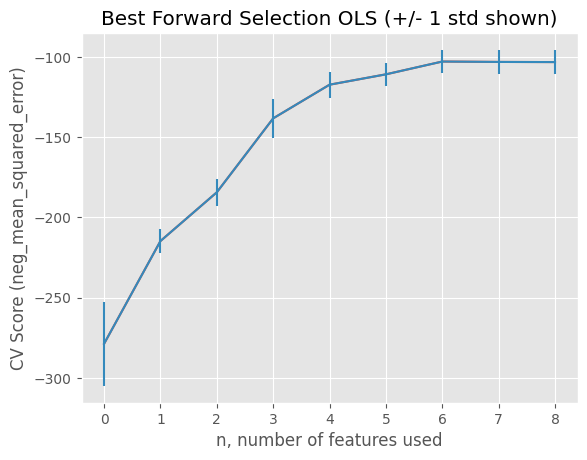

In [17]:
#Plot models' parameters vs. CV score
sns.lineplot(best_models_forward_select, x = 'n_params', y = 'cv_score')
plt.errorbar(x = best_models_forward_select['n_params'], y = best_models_forward_select['cv_score'], yerr = best_models_forward_select['cv_score_std'])
plt.title('Best Forward Selection OLS (+/- 1 std shown)')
plt.ylabel('CV Score (neg_mean_squared_error)')
plt.xlabel('n, number of features used')
plt.show()

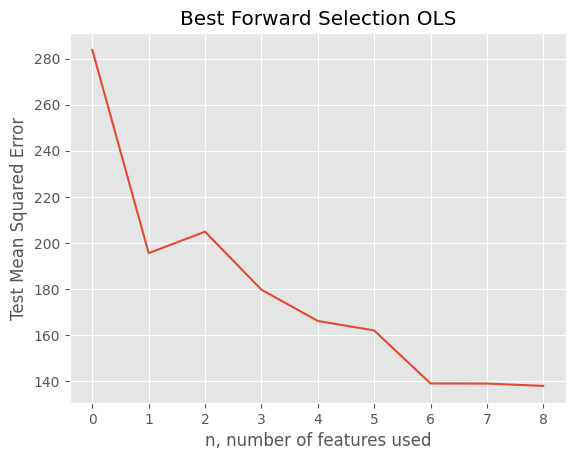

In [18]:
#Plot models' parameters vs. TestMSE
sns.lineplot(best_models_forward_select, x = 'n_params', y = 'test_mse')
plt.title('Best Forward Selection OLS')
plt.ylabel('Test Mean Squared Error')
plt.xlabel('n, number of features used')
plt.show()

In [19]:
forward_selection_OLS_model = best_models_forward_select.iloc[6]
forward_selection_OLS_model

model                                          LinearRegression()
is_ols                                                       True
scaled_data                                                 False
n_params                                                        6
parameters      [cement, age, superplasticizer, slag, flyash, ...
coefficients    [0.10607090811321253, 0.12575693797359566, 0.3...
intercept                                                20.99748
cv_score                                              -102.899464
cv_score_std                                              7.23299
test_mse                                               139.027926
Name: 6, dtype: object

The ideal OLS model selected using the forward selection method was the 6 parameter model since the 5-parameter model isn't within one standard deviation of the model with the maximum cross-validation score.  

The coefficients used in the model are cement, age, superplasticizer, slag, flyash, and water along with an intercept.  When this model predicts on the test set, the mean squared error is 139.03 (the baseline was 283.73).  It should be noted that the 5-parameter model using forward selection found a different subset of features than the best subset method since superplasticizer was added to the model in the 3-parameter model.

This method took 0.6 seconds to execute.  This is much more efficient than the best subset method as it models only 1+p(p+1)/2 times.

### Backward Selection:

In [20]:
best_models_backward_select = pd.DataFrame(dummy_reg_dict)

predictors = X_train.columns

for i in range(1, 8):
    new_model = linear_model_selection.backwardSelection(X_train, y_train, X_test, y_test, predictors, regressor='OLS')
    best_models_backward_select = pd.concat([best_models_backward_select, new_model], axis=0, ignore_index=True)
    predictors = best_models_backward_select.loc[i]['parameters']
    
all_param_model = linear_model_selection.getBestKModel(X_train, y_train, X_test, y_test, k=8, regressor = 'OLS')
best_models_backward_select = pd.concat([best_models_backward_select, all_param_model], axis=0, ignore_index=True)

Processed 8 model(s) on 7 predictor(s).
Processed 7 model(s) on 6 predictor(s).
Processed 6 model(s) on 5 predictor(s).
Processed 5 model(s) on 4 predictor(s).
Processed 4 model(s) on 3 predictor(s).
Processed 3 model(s) on 2 predictor(s).
Processed 2 model(s) on 1 predictor(s).
Processed 1 model(s) on 8 predictor(s)


In [21]:
best_models_backward_select.sort_values('n_params', inplace=True)
best_models_backward_select.reset_index(drop=True, inplace=True)
best_models_backward_select

,model,is_ols,scaled_data,n_params,parameters,coefficients,intercept,cv_score,cv_score_std,test_mse
0,DummyRegressor(),False,False,0,None,None,None,-278.676149,26.268613,283.728777
1,LinearRegression(),True,False,1,[cement],[0.07792767537004329],13.894509,-214.700791,7.410911,195.566040
2,LinearRegression(),True,False,2,"[cement, age]","[0.07464030127415472, 0.09049735479738762]",10.705233,-184.343140,8.397467,204.866418
3,LinearRegression(),True,False,3,"[cement, water, age]","[0.06934747281964472, -0.27025022848843683, 0....",60.183495,-153.101790,10.420344,163.718269
4,LinearRegression(),True,False,4,"[cement, slag, water, age]","[0.08419471576690608, 0.06815936622855842, -0....",55.661888,-121.751727,6.736899,139.783820
5,LinearRegression(),True,False,5,"[cement, slag, flyash, water, age]","[0.11315050495625445, 0.09724247649332822, 0.0...",29.23165,-104.603482,6.715694,135.349416
6,LinearRegression(),True,False,6,"[cement, slag, flyash, water, superplasticizer...","[0.10607090811321253, 0.08865757382480535, 0.0...",20.99748,-102.899464,7.232990,139.027926
7,LinearRegression(),True,False,7,"[cement, slag, flyash, water, superplasticizer...","[0.10774408025097179, 0.0905500599769832, 0.07...",17.067564,-103.148411,7.421625,138.970882
8,LinearRegression(),True,False,8,"[cement, slag, flyash, water, superplasticizer...","[0.11245418761334908, 0.09627841251483628, 0.0...",-0.819576,-103.239761,7.485769,137.955851


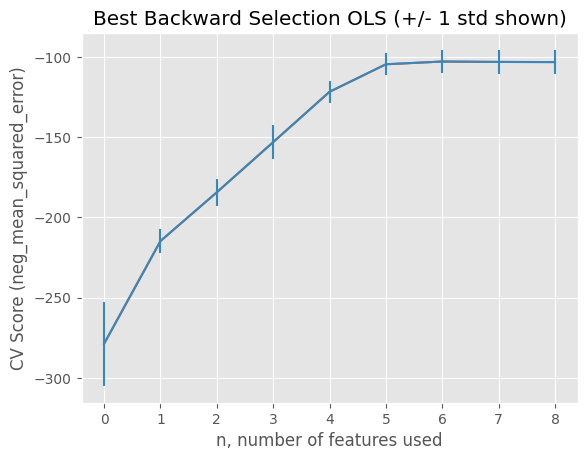

In [22]:
#Plot models' parameters vs. CV score
sns.lineplot(best_models_backward_select, x = 'n_params', y = 'cv_score')
plt.errorbar(x = best_models_backward_select['n_params'], y = best_models_backward_select['cv_score'], yerr = best_models_backward_select['cv_score_std'])
plt.title('Best Backward Selection OLS (+/- 1 std shown)')
plt.ylabel('CV Score (neg_mean_squared_error)')
plt.xlabel('n, number of features used')
plt.show()

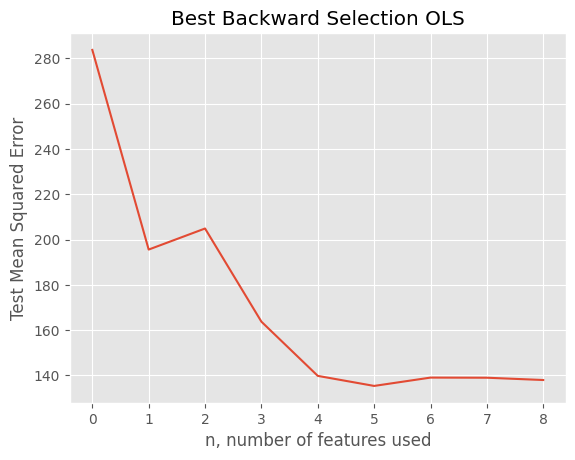

In [23]:
#Plot models' parameters vs. TestMSE
sns.lineplot(best_models_backward_select, x = 'n_params', y = 'test_mse')
plt.title('Best Backward Selection OLS')
plt.ylabel('Test Mean Squared Error')
plt.xlabel('n, number of features used')
plt.show()

In [24]:
backward_selection_OLS_model = best_models_backward_select.iloc[5]
backward_selection_OLS_model

model                                          LinearRegression()
is_ols                                                       True
scaled_data                                                 False
n_params                                                        5
parameters                     [cement, slag, flyash, water, age]
coefficients    [0.11315050495625445, 0.09724247649332822, 0.0...
intercept                                                29.23165
cv_score                                              -104.603482
cv_score_std                                             6.715694
test_mse                                               135.349416
Name: 5, dtype: object

In [25]:
backward_selection_OLS_model.coefficients

array([ 0.1131505 ,  0.09724248,  0.08659487, -0.23522754,  0.12612054])

The ideal OLS model selected using the forward selection method was the 5-parameter model since it's within one standard deviation of the model with the maximum cross-validation score (6 parameters: -102.90 +/- 7.23).  

The coefficients used in the model are cement, slag, flyash, water and age along with an intercept.  When this model is trained on the entire training set and tested on the test set, the mean squared error is 135.35 (the baseline was 283.73).  This method produced the same result as the best subset method. 

This method took 0.7 seconds to execute.  This is much more efficient than the best subset method as it models only 1+p(p+1)/2 times.